<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Classification with K-Nearest Neighbors

_Authors: Kiefer Katovich (SF), Alexander Barriga (SF), Joseph Nelson (DC)_

---

### Learning Objectives
- Understand the difference between classification and regression models.
- Explore the k-nearest neighbors (KNN) algorithm visually and in pseudocode.
- Explain the differences between distance metrics and explore the two most common kinds.
- Apply KNN classification to the Wisconsin Breast Cancer data set.
- Practice manually performing stratified cross-validation.
- Visually examine the effect of k neighbors on the decision boundary.
- Explain the effect of choosing k on the bias-variance tradeoff.

### Lesson Guide
- [Introduction: Classification vs. Regression](#intro)
- [K-nearest Neighbors, Visually](#knn-visual-intro)
- [The K-Nearest Neighbors (KNN) Algorithm](#knn)
    - [A Note on Parametric vs. Nonparametric Methods](#nonparametric)
- [The KNN Distance Metric](#distance)
    - [Euclidean Distance](#euclidean)
    - [Manhattan Distance](#manhattan)
- [Load the Wisconsin Breast Cancer Data Set](#wisconsin)
    - [Rename Columns and Subset the Data](#rename-subset)
    - [Encode the Target as a Binary Class](#target)
- [Examine the Correlation Structure of the Data Set](#correlations)
    - [Use a Heatmap](#heatmap)
    - [Use a Pairplot](#pairplot)
- [Using Scikit-Learn's `KNeighborsClassifier` and `StratifiedKFold`](#kneighborsclassifier)
    - [Create the Target and Predictors](#target-predictors)
    - [Standardize the Predictor Matrix](#standardize)
    - [Write a Function to Manually Perform the Cross-Validation Procedure](#manual-cv)
    - [Calculate the "Baseline" Accuracy](#baseline)
    - [Cross-Validate the Mean Accuracy With Five Neighbors](#cv-knn5)
    - [Cross-Validate the Mean Accuracy with One Neighbor](#cv-knn5)
- [Visualize the KNN Decision Boundary](#visualize-knn)
- [How is Bias-Variance Affected by the Number of Neighbors?](#bias-variance)
- [Additional Resources](#resources)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='intro'></a>
## Introduction: Regression vs. Classification

We've discussed the difference between continuous and discrete numbers. We've predicted continuous numbers using regression. But what about discrete numbers?

Think back to the wine quality data set we've used in the past. We used linear regression to predict the quality on a zero–10 scale. What if we just wanted to predict whether wine was good or bad? Red or white? 

Classification algorithms do just that — they predict categories or classes. They split the data into groups and place new data into those groups. 

![](http://ipython-books.github.io/images/ml.png "Best Split vs Best Fit")

<a id='knn-visual-intro'></a>

---

### K-Nearest Neighbors (KNN), Visually

**KNN works in a similar way to how humans might approach classification. Below we have some red and blue dots:**
![Alt text](http://blog.yhat.com/static/img/knn_reds_and_blues.png "Some Dots")

**A new dot appears without a color. We need to decide which color it's most likely going to be.**
![Alt text](http://blog.yhat.com/static/img/knn_new_point.png "A New Dot Appears")

**We compare it to its three nearest neighbors — its neighbors are more often red, so we label it red.**
![Alt text](http://blog.yhat.com/static/img/knn_new_point_pred.png "3 Nearest Neighbors")

**What if we increase the number of neighbors to consider to five?**
![Alt text](http://blog.yhat.com/static/img/knn_new_point_pred_blue.png "5 Nearest Neighbors")

**This is, in essence, the k-nearest neighbors (KNN) algorithm. The k represents the number of "neighbors" you consider.**

> ***Images above credited to the [yhat blog](http://blog.yhat.com/).***

<a id='knn'></a>

## The KNN Algorithm

---

K-nearest neighbors takes a different approach to modeling than we've been practicing with linear models. In order to estimate a value (regression) or class membership (classification), the algorithm finds the observations in its training data that are "nearest" to the observation it has to predict. It then averages or takes a vote of those training observations' target values to estimate the value for the new data point.

Distance is usually calculated using the Euclidean distance. The "k" in KNN refers to the number of nearest neighbors contributing to the prediction. 

Today we'll only be looking at KNN in the context of classification.

**The KNN can be concisely represented with pseudocode:**

```
for unclassified_point in sample:
    for known_point in known_class_points:
        calculate distances (euclidean or other) between known_point and unclassified_point
    for k in range of specified_neighbors_number:
        find k_nearest_points in known_class_points to unclassified_point
    assign class to unclassified_point using "votes" from k_nearest_points
```

> **Note**: In the case of ties, scikit-learn's `KNeighborsClassifier()` will choose the first class (when weights are uniform). If this is unappealing, you can change the weights keyword argument to `'distance'`. More on this later.






---

<a id='nonparametric'></a>

### A Note on Parametric vs. Nonparametric Methods

So far, all of our tests and methods have been **parametric**, meaning we've assumed that our data falls into a certain distribution. In linear regression, our parameters are the coefficients in our model and our estimate of the target is calculated from these parameters.

There are alternatives for cases in which we can't assume a particular distribution for our data — or we choose not to. When we make no assumptions about the distribution for our data, we call our data **nonparametric**. For nearly every parametric test, there's a nonparametric analog available. The KNN model is an example of a nonparametric model. You can see that there are no coefficients for the different predictors and our estimate is not represented by a formula of our predictor variables.

<a id='distance'></a>
## The KNN Distance Metric

---
KNN typically uses one of two distance metrics: **Euclidean**('yoo-klid-ee-uhn') or **Manhattan**. Other distance metrics are possible, but rarer. Sometimes it makes sense to create your own distance function.

<a id='euclidean'></a>
### Euclidean Distance

Recall the famous Pythagorean theorem:
![Alt text](http://ncalculators.com/images/pythagoras-theorem.gif)

We can apply the theorem to calculate the distance between two points. This is called Euclidean distance. 

![Alt text](http://rosalind.info/media/Euclidean_distance.png)

### $$\text{Euclidean  distance}=\sqrt{(x_1-x_2)^2+(y_1-y_1)^2}$$

There are many different distance metrics, but Euclidean is the most common (and the default in scikit-learn).



---

<a id='manhattan'></a>
### Manhattan Distance (Taxicab Distance)

Another way to measure the distance between two points is to take the sum of the absolute value of their differences. 

### $$ D = \sum_{i=1}^n | x_i - y_i | $$

The name "Manhattan distance" comes from the fact that taxis in Manhattan must drive from point A to point B on streets that force traffic to flow forward or backward and left or right — but never diagonally. 
![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Manhattan_distance_bgiu.png/261px-Manhattan_distance_bgiu.png)
![](https://pbs.twimg.com/media/CgIlqLTWEAAedKB.jpg)

**Note that the Manhattan distance is a less common choice.**
- Manhattan distance is more restrictive than Euclidean distance in terms of how distance is measured.
- [Manhattan distance comes from $L_{p = 1}$ space and Euclidean distance comes from $L_{p = 2}$ space](https://en.wikipedia.org/wiki/Lp_space).
- In practice, we can cross-validate KNN using both types of distances to see which performs best. 

![](http://www.improvedoutcomes.com/docs/WebSiteDocs/image/diagram_euclidean_manhattan_distance_metrics.gif)

<a id='wisconsin'></a>

## Load the Wisconsin Breast Cancer Data Set

---

Below we'll be testing out the KNN classification algorithm on the [Wisconsin Breast Cancer data set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data).

> **Note:** (The file as is saved as `.data` suffix, but is actually formatted as a `.csv`).

In [2]:
bcw = pd.read_csv('./datasets/wdbc.data', header=None, index_col=None)

In [3]:
raw_file = ''
file = './datasets/wdbc.names'
with open(file, 'r') as f:
    raw_file = f.read()


In [4]:
clean = [[float(row[i]) if row[i].isdigit() else row[i] for i in range(len(row))]
             for row in [line.split(",") for line in raw_file.splitlines()]]
clean

[['1. Title: Wisconsin Diagnostic Breast Cancer (WDBC)'],
 [''],
 ['2. Source Information'],
 [''],
 ['a) Creators: '],
 [''],
 ['\tDr. William H. Wolberg', ' General Surgery Dept.', ' University of'],
 ['\tWisconsin', '  Clinical Sciences Center', ' Madison', ' WI 53792'],
 ['\twolberg@eagle.surgery.wisc.edu'],
 [''],
 ['\tW. Nick Street', ' Computer Sciences Dept.', ' University of'],
 ['\tWisconsin', ' 1210 West Dayton St.', ' Madison', ' WI 53706'],
 ['\tstreet@cs.wisc.edu  608-262-6619'],
 [''],
 ['\tOlvi L. Mangasarian', ' Computer Sciences Dept.', ' University of'],
 ['\tWisconsin', ' 1210 West Dayton St.', ' Madison', ' WI 53706'],
 ['\tolvi@cs.wisc.edu '],
 [''],
 ['b) Donor: Nick Street'],
 [''],
 ['c) Date: November 1995'],
 [''],
 ['3. Past Usage:'],
 [''],
 ['first usage:'],
 [''],
 ['\tW.N. Street', ' W.H. Wolberg and O.L. Mangasarian '],
 ['\tNuclear feature extraction for breast tumor diagnosis.'],
 ['\tIS&T/SPIE 1993 International Symposium on Electronic Imaging: Scien

---

<a id='rename-subset'></a>
### Rename Columns and Subset the Data

The following attributes are the columns of the data set.

The column names are taken from the data set's information file (check it out for more details):

`./assets/datasets/wdbc.names`

You can open it with a text editor of your choice.

      Attribute                     
    --------------------------------------------
    1. Sample code number [subject ID].
    2. Class
    3. Cell nucleus mean radius.
    4. Cell nucleus SE radius.
    5. Cell nucleus worst radius.
    6. Texture mean.
    7. Texture SE.
    8. Texture worst.
    9. Perimeter mean.
    10. Perimeter SE.
    11. Perimeter worst.
    12. Area mean.
    13. Area SE.
    14. Area worst.
    15. Smoothness mean.
    16. Smoothness SE.
    17. Smoothness worst.
    18. Compactness mean.
    19. Compactness SE.
    20. Compactness worst.
    21. Concavity mean.
    22. Concavity SE.
    23. Concavity worst.
    24. Concave points mean.
    25. Concave points SE.
    26. Concave points worst.
    27. Symmetry mean.
    28. Symmetry SE.
    29. Symmetry worst.
    30. Fractal dimension mean.
    31. Fractal dimension SE.
    32. Fractal dimension worst.
   
**Using the list provided, reassign the column names in the data set.**

In [5]:
column_names = ['id','malignant',
                'nucleus_mean','nucleus_se','nucleus_worst',
                'texture_mean','texture_se','texture_worst',
                'perimeter_mean','perimeter_se','perimeter_worst',
                'area_mean','area_se','area_worst',
                'smoothness_mean','smoothness_se','smoothness_worst',
                'compactness_mean','compactness_se','compactness_worst',
                'concavity_mean','concavity_se','concavity_worst',
                'concave_pts_mean','concave_pts_se','concave_pts_worst',
                'symmetry_mean','symmetry_se','symmetry_worst',
                'fractal_dim_mean','fractal_dim_se','fractal_dim_worst']


In [6]:
selected_columns =  ['id','malignant','nucleus_mean','texture_mean','perimeter_mean','area_mean',
                     'smoothness_mean','compactness_mean','concavity_mean','concave_pts_mean',
                     'symmetry_mean','fractal_dim_mean']

In [13]:
df2 = bcw.filter(regex='ean$', axis=1)

In [14]:
df2.head()

,nucleus_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_pts_mean,symmetry_mean,fractal_dim_mean
0,17.99,1001.0,0.3001,0.07871,8.589,0.04904,0.03003,17.33,0.1622,0.2654
1,20.57,1326.0,0.0869,0.05667,3.398,0.01308,0.01389,23.41,0.1238,0.1860
2,19.69,1203.0,0.1974,0.05999,4.585,0.04006,0.02250,25.53,0.1444,0.2430
3,11.42,386.1,0.2414,0.09744,3.445,0.07458,0.05963,26.50,0.2098,0.2575
4,20.29,1297.0,0.1980,0.05883,5.438,0.02461,0.01756,16.67,0.1374,0.1625


**Remove the columns pertaining to the standard deviation and "worst" measurements, leaving only the mean measurement columns.**

In [7]:
bcw.columns = column_names

In [8]:
bcw.head()

,id,malignant,nucleus_mean,nucleus_se,nucleus_worst,texture_mean,texture_se,texture_worst,perimeter_mean,perimeter_se,...,concavity_worst,concave_pts_mean,concave_pts_se,concave_pts_worst,symmetry_mean,symmetry_se,symmetry_worst,fractal_dim_mean,fractal_dim_se,fractal_dim_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


---
<a id='target'></a>
### Encode the Target Class Variable `malignant` to be a Binary 0 vs. 1

The `malignant` class target variable is coded as "B" for benign and "M" as malignant. 

We need to recode this to a binary integer for classification:
 - Encode `malignant` as 1.
 - Encode `benign` as 0.
 
`malignant` is assigned to 1 because our goal is to predict malignant tumors using the data. In binary classification problems, the category we want to predict is typically encoded as 1.

In [9]:
bcw['malignant'] = (bcw['malignant'] == 'M')*1

In [10]:
bcw.iloc[:,1:].head()

,malignant,nucleus_mean,nucleus_se,nucleus_worst,texture_mean,texture_se,texture_worst,perimeter_mean,perimeter_se,perimeter_worst,...,concavity_worst,concave_pts_mean,concave_pts_se,concave_pts_worst,symmetry_mean,symmetry_se,symmetry_worst,fractal_dim_mean,fractal_dim_se,fractal_dim_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<a id='correlations'></a>
## Examine the Correlation Structure of the Data Set

---

You should exclude the `id` column, as it's just an indicator variable for the subject.

<a id='heatmap'></a>
### Method 1: Plot a Heatmap of the Correlation Matrix

Plot a Seaborn heatmap of the correlation matrix to visually examine which variables are correlated and anti-correlated and to what degree.

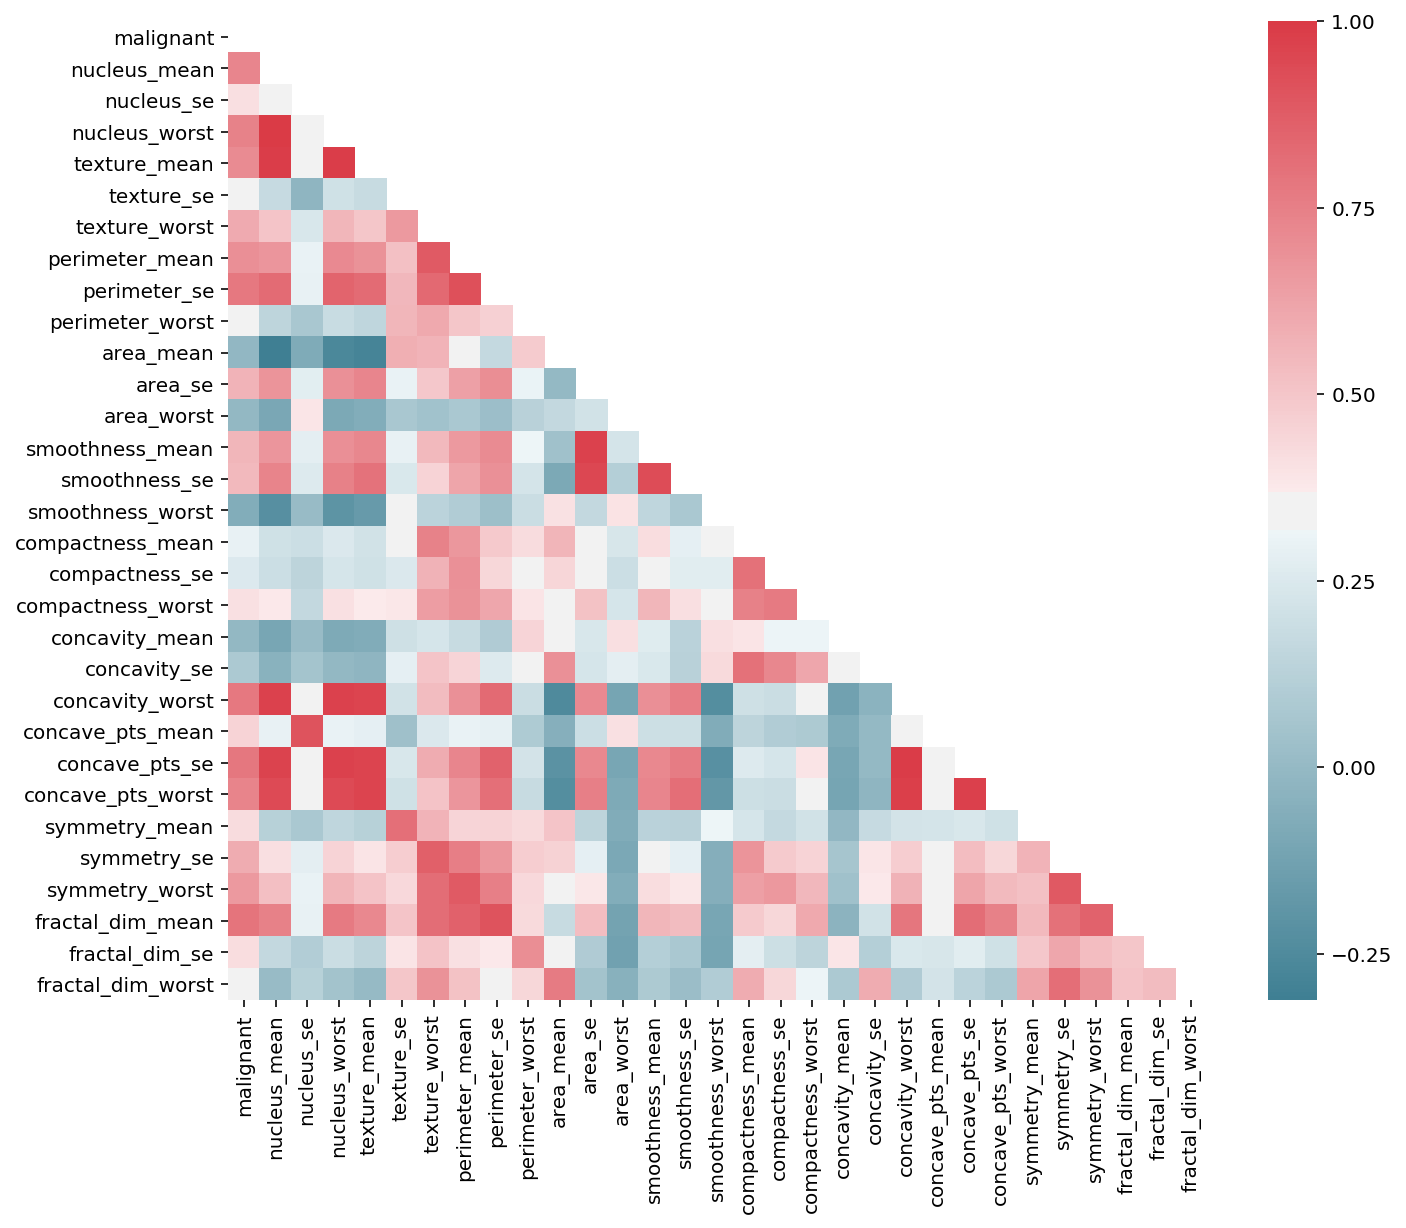

In [11]:
# Compute the correlation matrix
corr = bcw.iloc[:,1:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True)


In [11]:
c = bcw.iloc[:,1:].corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

so2 = pd.DataFrame(so)
so2[so2[0] != 1.0]

,,0
nucleus_worst,nucleus_mean,0.997855
nucleus_mean,nucleus_worst,0.997855
concave_pts_se,concavity_worst,0.993708
concavity_worst,concave_pts_se,0.993708
nucleus_mean,texture_mean,0.987357
texture_mean,nucleus_mean,0.987357
nucleus_worst,texture_mean,0.986507
texture_mean,nucleus_worst,0.986507
concave_pts_worst,concavity_worst,0.984015
concavity_worst,concave_pts_worst,0.984015


<a id='pairplot'></a>
### Method 2: Use Seaborn's `pairplot()` Function to Visualize Relationships Between Variables

When you have a small number of predictor variables, Seaborn's `pairplot()` function will give you a more detailed, visual look at the relationships between them. The pairplot is similar to a correlation matrix but displays scatterplots of variable pairs. Along the diagonal line are histograms showing the distribution of each variable.

One of the most appealing aspects of the `pairplot` function for classification tasks is that the scatterplots and histograms can be split along a `hue` variable. If we use the `malignant` target class as the hue, we're able to see how the classes are distributed across these variables as well.

Plot data using Seaborn's `pairplot()` function. The hue will be the class variable "malignant." The variables will be the other columns excluding, of course, the subject ID column. This function can take some time to run.

> **Note:** Most of these predictors are highly correlated with the class variable. This is an indication that our classifier is likely to perform well.

In [ ]:
sns.pairplot(bcw.iloc[:,1:], hue='malignant')

In [15]:
df = bcw[selected_columns]

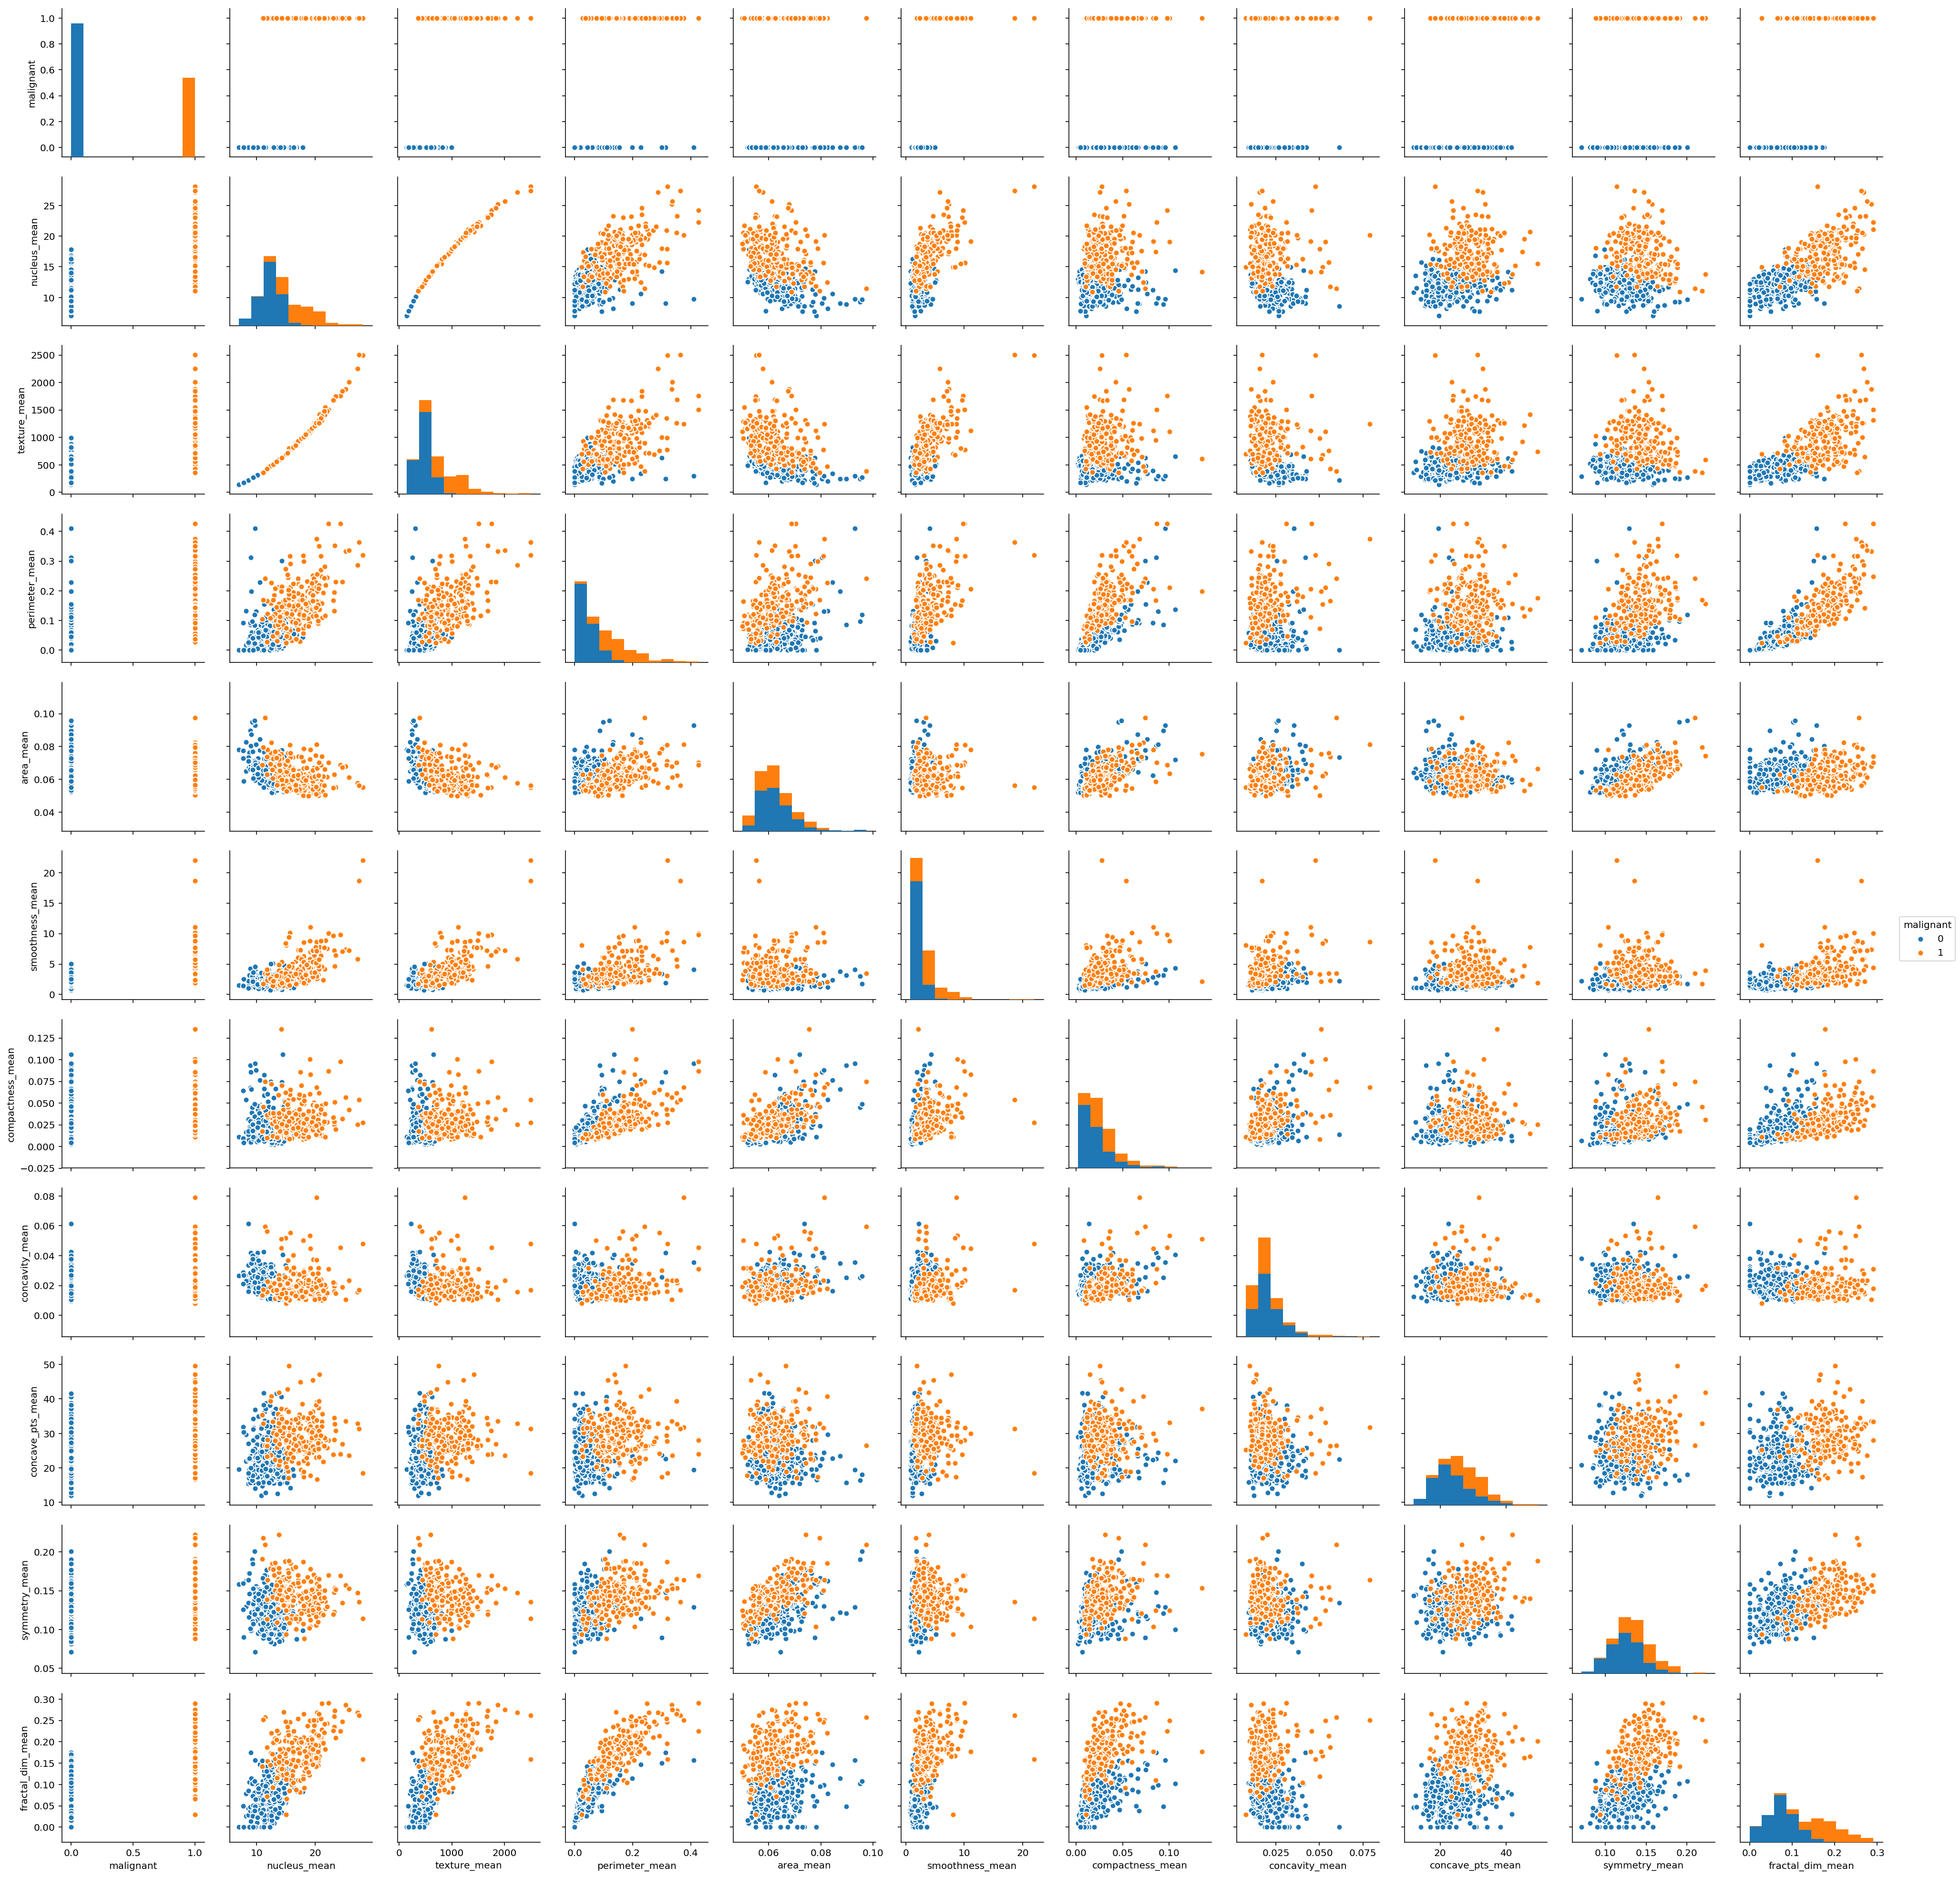

In [16]:
sns.pairplot(df.iloc[:,1:], hue='malignant')


<a id='kneighborsclassifier'></a>

## Using Scikit-Learn's `KNeighborsClassifier` and `StratifiedKFold`

---

Let's see how scikit-learn's KNN classifier performs on our data set, predicting the `malignant` target class using cross-validation.

Load the KNN classifier:
```python
from sklearn.neighbors import KNeighborsClassifier
```

**We're going to set some arguments when instantiating the model:**
1. **n_neighbors**: Specifies how many neighbors will vote on the class.
2. **weights**: Uniform weights indicate that all neighbors have the same weight.
3. **metric** and **p**: when distance is `minkowski` (the default) and `p == 2` (the default), _it's equivalent to the Euclidean distance metric_.

Also load scikit-learn's `StratifiedKFold` from the `model_selection` module:
```python
from sklearn.model_selection import StratifiedKFold
```

The `StratifiedKFold` object will return cross-validation _indices_ that you can use to subset your data — for example, in a loop that runs the model and tests it. 

This is the **stratified** version of the `KFold` class. Stratification ensures that there are equal proportions of the predicted class in each train-test fold. This is a best practice in classification tasks.

> **Note:** The `cross_val_score` can also stratify for you. However, you should get familiar with using indices for cross-validation on data. Being able perform cross-validation at a more "manual" level allows for a lot more power and customization. It also reinforces what's happening in your head during cross-validation, as you have to divide up the data yourself with the indices.



In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

<a id='target-predictors'></a>
### Create Your Target Vector and Predictor Matrix

The target should be the binary `malignant` column — the predictors are up to you.

In [18]:
y = df['malignant']
X = df.iloc[:,2:]
X = df[['nucleus_mean','texture_mean','perimeter_mean']]

<a id='standardize'></a>

### Standardize the Predictor Matrix

Standardization should be done for the predictors when using a KNN model. But why? 

Remember that KNN finds the nearest neighbors according to a distance metric. If the predictors are left unstandardized, then it's possible that some predictors will have an unfair impact on the distance measure simply because they're on a larger scale than other variables.

In [19]:
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X)

<a id='cv-inds'></a>
### Create the Cross-Validation Indices Using `StratifiedKFold`

`StratifiedKFold` is instantiated with `n_splits` - number of train-test pairs desired.

The built-in `.split()` function will take a predictor matrix, target arrays, and return the training and testing indices.

> **Note:** The `split()` function will return a Python *generator*. This can be iterated but works differently from a list in that, once iterated, it'll be "empty". You can convert the output to a list using a list comprehension if you need to use the indices multiple times.

In [21]:
skf = StratifiedKFold(n_splits=5)
indices = skf.split(X, y)
indices = [[train,test] for train, test in indices]

In [26]:
for i in range(5):
    print len(indices[i][0])

454
454
456
456
456


<a id='manual-cv'></a>
### Write a Function to Manually Perform Cross-Validation Using Your Stratified Indices

Now that we have the indices — row indexes for our train/test splits — write a function that will:
- Split the x and y into training and testing subsets.
- Fit a KNN classifier on the training set.
- Calculate the accuracy of the classifier on the testing set.
- Store the accuracies for each fold and return them as a list.

In [27]:
scores = []
for i in range(len(indices)):
    model = KNeighborsClassifier(n_neighbors=5).fit(Xs[indices[i][0]], y[indices[i][0]])
    scores.append(model.score(Xs[indices[i][1]], y[indices[i][1]]))
print scores
print np.mean(scores)

[0.8695652173913043, 0.9130434782608695, 0.9380530973451328, 0.9292035398230089, 0.9292035398230089]
0.9158137745286649


<a id='baseline'></a>
### Calculate the "Baseline" Accuracy

Before we can evaluate whether our classifier's accuracy is good or bad, we need to know the baseline accuracy.

**The baseline accuracy is the proportion of the majority class.**

For a binary classification, this means that the baseline accuracy is the percent of the data set that's labeled malignant or benign, depending on whether `malignant` or `benign` is greater. This can be calculated as:

```python
baseline = np.mean(y)  # if np.mean(y) is >= 0.5
baseline = 1. - np.mean(y) # if np.mean(y) is < 0.5
```

**It is critical that you know your baseline accuracy,**

Imagine your data set had, for example, 95 ones and 5 zeroes, and you got 95 percent accuracy using KNN. If you hadn't looked at your baseline accuracy, you may conclude that your classifier is doing well, when in fact it's doing no better than chance. The classifier could have guessed only 1s and gotten a 95 percent accuracy.

In [28]:
baseline = 1 - np.mean(y)
baseline

0.6274165202108963

<a id='cv-knn5'></a>
### Cross-Validate the Mean Accuracy for a KNN Model With Five Neighbors

In [29]:
scores = []
for i in range(len(indices)):
    model = KNeighborsClassifier(n_neighbors=5).fit(Xs[indices[i][0]], y[indices[i][0]])
    scores.append(model.score(Xs[indices[i][1]], y[indices[i][1]]))
print scores
print np.mean(scores)

[0.8695652173913043, 0.9130434782608695, 0.9380530973451328, 0.9292035398230089, 0.9292035398230089]
0.9158137745286649


<a id='cv-knn1'></a>
### Cross-Validate the Mean Accuracy for a KNN Model With One Neighbor

As you can see, the mean cross-validated accuracy is high with five neighbors. 

Let's see what it's like when we only use one neighbor:

In [30]:
scores = []
for i in range(len(indices)):
    model = KNeighborsClassifier(n_neighbors=1).fit(Xs[indices[i][0]], y[indices[i][0]])
    scores.append(model.score(Xs[indices[i][1]], y[indices[i][1]]))
print scores
print np.mean(scores)

[0.8260869565217391, 0.8521739130434782, 0.911504424778761, 0.8938053097345132, 0.911504424778761]
0.8790150057714505


<a id='visualize-knn'></a>

## Visualize the KNN Decision Boundary

---

Even with one neighbor, we can do quite well predicting the malignant observations.

Below you can load an interactive KNN visualization that shows how the decision boundary of a KNN classifier changes as the number of neighbors changes.

The `KNNBoundaryPlotter` class has four required arguments:

    KNNBoundaryPlotter (data, predictor1, predictor2, class_target)
    
By default, it will fit a visualization of the decision boundary across 1–100 nearest neighbors.

The boundary is where the classifier will vote for `malignant` or `benign` classes.

In [ ]:
import imp
plotter = imp.load_source('plotter', './knn_plotter.py')
from plotter import KNNBoundaryPlotter

kbp = KNNBoundaryPlotter(bcw, 'area_mean', 'symmetry_mean', 'malignant', nn_range=range(1,101))

kbp.knn_mesh_runner()
kbp.knn_interact()

<a id='bias-variance'></a>
### How Does Increasing the Number of Neighbors Impact the Bias and Variance of Your Model?

In [ ]:
# more generalised results therefore higher bias and less variance

<a id='resources'></a>

## Additional Resources

---


- Scott Foreman-Roe's [breakdown](http://scott.fortmann-roe.com/docs/BiasVariance.html) of the bias-variance tradeoff, featuring a discussion of KNN (required reading).
- A [detailed discussion](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/) of KNN.
- A lengthy example of KNN applied to [image classification](http://cs231n.github.io/classification/ ).
- If academic breakdowns are your thing, be sure to visit [this](http://me.seekingqed.com/files/intro_KNN.pdf) resource.
- Read the scikit-learn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on implementing KNN.
- Context on choosing the right [algorithm from scikit-learn](http://scikit-learn.org/stable/tutorial/machine_learning_map/).
- A deeper dive into [Euclidian distance](http://www.econ.upf.edu/~michael/stanford/maeb4.pdf).
- A classifier comparison from [scikit-learn](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) (this is also in our [repository](https://github.com/ga-students/DSI-DC-2/blob/master/curriculum/Week-04/4.01%20Intro%20to%20Classification/classification-methods.py)).